In [1]:
import dgl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import spatial
import scipy.spatial.distance as dist
import networkx as nx
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import torch
from sklearn.neighbors import KDTree

import torch.nn as nn
import torch.nn.functional as F


In [2]:
feats = h5py.File('/cosma5/data/dp004/dc-cues1/features/halo_features_s99','r+')    

In [3]:
positions = feats['Pos'][:] / 1000.

In [4]:
np.max(positions)

302.627625

# Scipy Tree

In [5]:
tree = spatial.cKDTree(positions)
feats.close()

In [7]:
%%time 

edgeList = tree.query_pairs(1.) # within 2 Mpc

CPU times: user 145 ms, sys: 4.71 ms, total: 150 ms
Wall time: 149 ms


In [8]:
sktree = KDTree(positions)

In [20]:
positions.shape

(290605, 3)

In [56]:
%%time 

edges, distances = sktree.query_radius(positions, r = 1.,
                                       return_distance = True)

CPU times: user 7.05 s, sys: 207 ms, total: 7.26 s
Wall time: 2.57 s


In [57]:
edges.shape

(290605,)

In [155]:
combi = [(idx, dest) for idx, destination in enumerate(edges)\
         for dest in destination if idx != dest]

In [156]:
combi =  set(tuple(sorted(t)) for t in combi)

In [157]:
len(combi)

52732

In [120]:
othercombi = [(idx, dest) for idx, destination in enumerate(edges) if len(destination) > 1 \
         for dest in destination if idx != dest]

In [121]:
othercombi = set(tuple(sorted(t)) for t in othercombi)

In [123]:
list(othercombi)[0]

(1521, 88125)

In [127]:
distances[1521][np.where(edges[1521] == 88125)]

array([0.91196783])

In [130]:
distance = [distances[idx][np.where(edges[idx] == destination)][0] for idx, destination in othercombi] 

In [131]:
distance

[0.9119678348507699,
 0.5710682567011119,
 0.5278057066638853,
 0.7939345968127735,
 0.7404558585621491,
 0.5724313646511104,
 0.7274648085953866,
 0.8445282531402527,
 0.8604496952405523,
 0.8245859391284244,
 0.9181445537216415,
 0.9248191091140429,
 0.3765820916235476,
 0.3989790692109869,
 0.8541739901116676,
 0.9729856960895655,
 0.8896429580649409,
 0.9902827502052025,
 0.718053636847993,
 0.6032949568765468,
 0.9708218174173555,
 0.6235971132834415,
 0.5615552282610933,
 0.955927183338874,
 0.9466324737427152,
 0.8338471146193871,
 0.47386182319436804,
 0.869787292257801,
 0.8150163820176564,
 0.8103054863692625,
 0.7897895793056998,
 0.8147703211761806,
 0.9465267589960881,
 0.5005535161296532,
 0.9478192056430605,
 0.8039090768065625,
 0.9465594489082808,
 0.4766735968257254,
 0.9347947116308943,
 0.8160968549879167,
 0.9591065563197279,
 0.9624241391873838,
 0.832620809464609,
 0.7837255259414457,
 0.8152337678184165,
 0.48585881662074143,
 0.923033106812524,
 0.7300845110742

In [64]:
#combi = set(tuple(sorted(t)) for t in combi)

In [69]:
dcombi = [distances[idx][d] for idx, destination in enumerate(edges) if len(destination) > 1 \
         for d, dest in enumerate(destination) if idx != dest ]

In [72]:
combi = set(tuple(sorted(t)) for t in combi)

In [74]:
dcombi = set(dcombi)

In [75]:
len(dcombi)

52732

In [76]:
len(combi)

52732

In [146]:
list(othercombi)[5]

(69923, 207283)

In [147]:
np.linalg.norm(positions[69923] - positions[207283])

0.5724313646511104

In [148]:
distance[5]

0.5724313646511104

In [15]:
src, dst = zip(*combi)


In [43]:
G = dgl.DGLGraph()
G.add_nodes(len(positions))
G.add_edges(src, dst)

In [44]:
G

DGLGraph(num_nodes=290605, num_edges=52732,
         ndata_schemes={}
         edata_schemes={})

In [45]:
src, dst = zip(*edgeList)

G = dgl.DGLGraph()
G.add_nodes(len(positions))
G.add_edges(src, dst)

In [46]:
G

DGLGraph(num_nodes=290605, num_edges=52732,
         ndata_schemes={}
         edata_schemes={})

In [7]:
features = np.column_stack([feats['M200c'][:], 
                    feats['R200c'][:],
                    feats['N_subhalos'][:],
                    feats['VelDisp'][:],
                    feats['Vmax'][:],
                    feats['Spin'][:],
                    feats['Fsub'][:],
                    feats['x_offset'][:]])

In [10]:
G_nx = nx.from_edgelist(edgeList)

SGs_nx = list(nx.connected_component_subgraphs(G_nx))

In [11]:
SGs = [G.subgraph(SG_nx.nodes()) for SG_nx in SGs_nx]

In [12]:
SGs[0].ndata

{}

In [13]:
SGs[0].nodes()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [14]:
SGs[0].edges()

(tensor([0, 0, 2, 2, 2, 5, 5, 5, 6, 7]),
 tensor([1, 8, 4, 3, 8, 1, 0, 8, 8, 1]))

In [15]:
SGs[0].parent_nid

tensor([152008, 160937,  39692, 160494,  82351, 136561, 115956,  65175, 203674])

In [16]:
# Looks like we lost the features from parent graph...

#for sg in SGs:
#    sg.ndata['feat'] = features[sg.parent_nid, : ]

In [17]:
SGs[0].ndata

{}

In [18]:
#Visualization

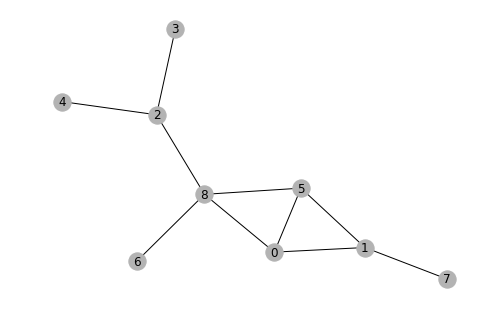

In [19]:
nx_G = SGs[0].to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [20]:
# Add pairwise distance (d, alpha) as edge feature